In [1]:
import sys
!{sys.executable} -m pip install ultralytics opencv-python-headless matplotlib pandas


In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [3]:
# yolo model
model = YOLO("yolov8n.pt")
model


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [4]:
VIDEO_PATH = "../data/office1.mp4"
OUTPUT_DIR = Path("../outputs/video_fps")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_FPS = 3  # low fps is sufficient for video imagery detection

cap = cv2.VideoCapture(VIDEO_PATH)
source_fps = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(source_fps / TARGET_FPS)

print(f"Video fps: {source_fps:.2f} → sampling every {frame_interval} frames")

frame_index = 0
saved_index = 0

records = []  # timestamps for plotting later on

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # skipping frames
    if frame_index % frame_interval != 0:
        frame_index += 1
        continue

    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # yolo prediction
    result = model.predict(frame_rgb, imgsz=640, conf=0.25)
    boxes = result[0].boxes.xyxy.cpu().numpy()
    classes = result[0].boxes.cls.cpu().numpy().astype(int)

    # for all classes 0 = "person"
    person_indices = [i for i, c in enumerate(classes) if c == 0]
    person_boxes = [boxes[i] for i in person_indices]
    people_count = len(person_boxes)

    # annotation with bounding boxes
    annotated = frame_rgb.copy()
    for box in person_boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        cv2.rectangle(annotated, (x1, y1), (x2, y2), (0,255,0), 2)


    out_path = OUTPUT_DIR / f"frame_{saved_index:04d}.jpg"
    cv2.imwrite(str(out_path), cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR))

    # timestamp → people_count
    timestamp = frame_index / source_fps
    records.append({"time_s": timestamp, "people": people_count})

    saved_index += 1
    frame_index += 1

cap.release()

df_video = pd.DataFrame(records)
df_video


Video fps: 25.00 → sampling every 8 frames

0: 384x640 6 persons, 1 bottle, 2 cups, 1 chair, 1 dining table, 2 laptops, 47.2ms
Speed: 4.6ms preprocess, 47.2ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 3 cups, 1 chair, 1 dining table, 1 laptop, 29.3ms
Speed: 1.7ms preprocess, 29.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 2 cups, 1 chair, 1 dining table, 1 laptop, 27.3ms
Speed: 1.4ms preprocess, 27.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 3 cups, 2 chairs, 1 dining table, 1 laptop, 27.4ms
Speed: 1.2ms preprocess, 27.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 3 cups, 1 chair, 1 dining table, 1 laptop, 28.2ms
Speed: 1.2ms preprocess, 28.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 3 cups, 1 chair, 1 di

,time_s,people
0,0.00,6
1,0.32,7
2,0.64,7
3,0.96,7
4,1.28,7
5,1.60,7
6,1.92,7
7,2.24,9
8,2.56,7
9,2.88,8


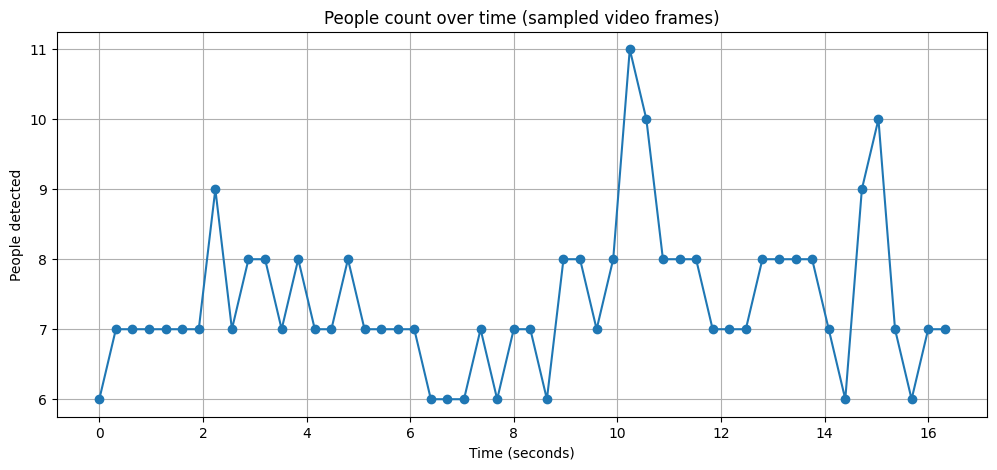

In [5]:
plt.figure(figsize=(12,5))
plt.plot(df_video["time_s"], df_video["people"], marker="o")
plt.xlabel("Time (seconds)")
plt.ylabel("People detected")
plt.title("People count over time (sampled video frames)")
plt.grid(True)
plt.show()
